In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-reviews/dataset.csv


In [2]:
import os
# try:
#   import ktrain
# except:
#   !pip install ktrain
#   os.kill(os.getpid(), 9)
# import ktrain

from sklearn.model_selection import train_test_split
!pip install tf-keras
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))
os.environ['TF_USE_LEGACY_KERAS'] = '1'
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))

try:
  import ktrain
except:
  !pip install ktrain
  import ktrain
from ktrain import text
from ktrain.text import texts_from_df


import seaborn as sns
import matplotlib.pyplot as plt
import re

import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
# spacy.require_gpu()

# wordcloud 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
TF_USE_LEGACY_KERAS: None
TF_USE_LEGACY_KERAS: 1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 67.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 47.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - d

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 24 15:57:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              32W / 250W |    278MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
reviews = pd.read_csv("/kaggle/input/steam-reviews/dataset.csv")

In [5]:
reviews.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


## Prepare Data

In [7]:
# first things first remove any duplicates
reviews.drop_duplicates(inplace=True)

In [8]:
# drop reviews that are exactly the same - a rare event
reviews.drop_duplicates(subset="review_text", inplace=True)

In [9]:
reviews.shape

(4473474, 5)

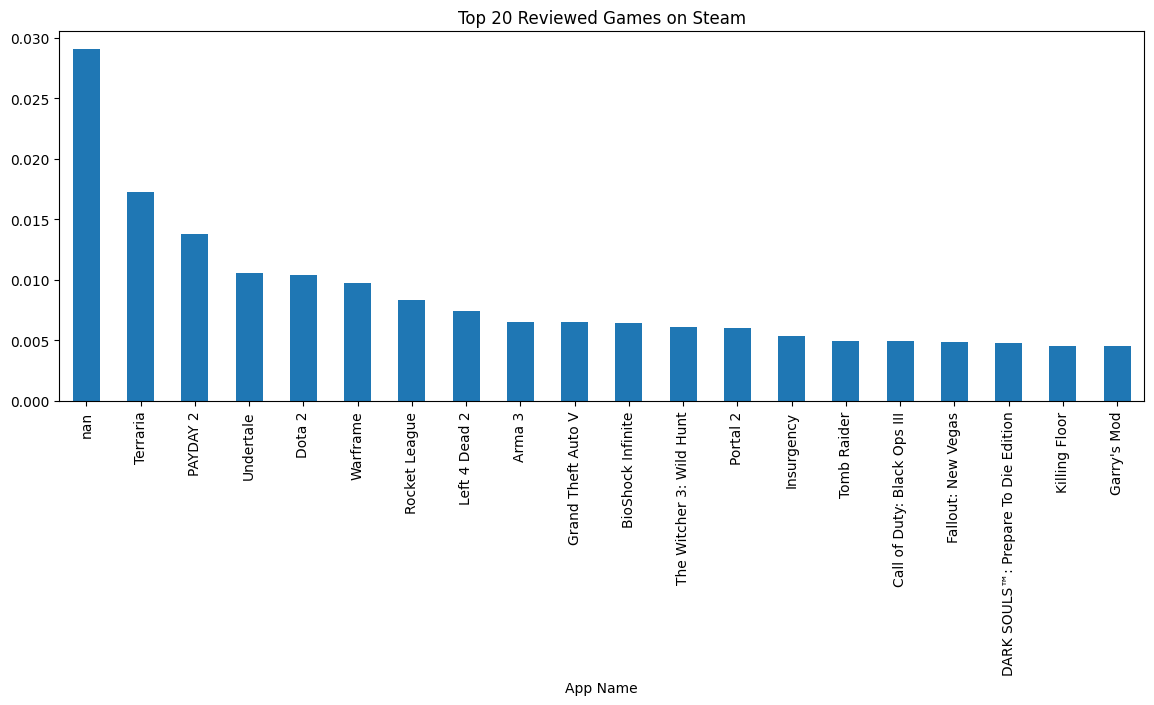

In [10]:
fig = plt.figure()
fig.set_figwidth(14)
reviews["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

In [11]:
# remove null values
reviews = reviews[~reviews["app_name"].isnull()].copy(deep=True)
reviews = reviews[~reviews["review_text"].isnull()].copy(deep=True)

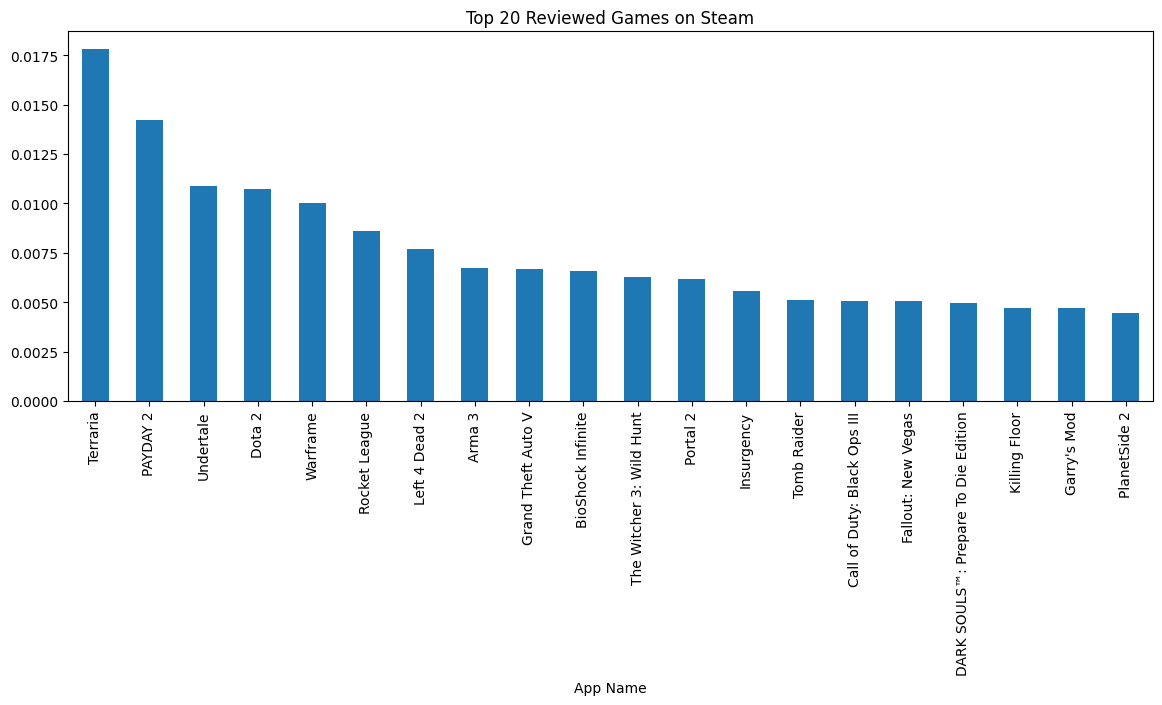

In [12]:
fig = plt.figure()
fig.set_figwidth(14)
reviews["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.title("Top 20 Reviewed Games on Steam")
plt.xlabel("App Name")
plt.show()

In [13]:
# remove reviews that only say early access review
reviews = reviews[(reviews["review_text"] != " Early Access Review")].copy(deep=True)

In [14]:
reviews["word_count"] = reviews["review_text"].apply(lambda x: len(x.split()))

reviews.head()

,app_id,app_name,review_text,review_score,review_votes,word_count
0,10,Counter-Strike,Ruined my life.,1,0,3
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1,449
2,10,Counter-Strike,This game saved my virginity.,1,0,5
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0,47
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1,6


In [15]:
# count words without punctuations
reviews["count_no_punct"] = reviews["review_text"].apply(lambda x: len(re.findall(r'\w+', x)))

In [16]:
# majority of reviews are under 1000 words
# remove reviews that are more than 1000 words
reviews = reviews[reviews["count_no_punct"] < 1001].copy(deep=True)

In [17]:
# reviews that are too short can also be hard to classify
# remove any reviews less than 100 words - since we are taking a subset and this dataset is quite robust
reviews = reviews[reviews["count_no_punct"] > 100].copy(deep=True)

In [18]:
# convert review scores to 0 and 1
reviews["review_score"] = reviews["review_score"].apply(lambda x: 0 if x == -1 else 1)

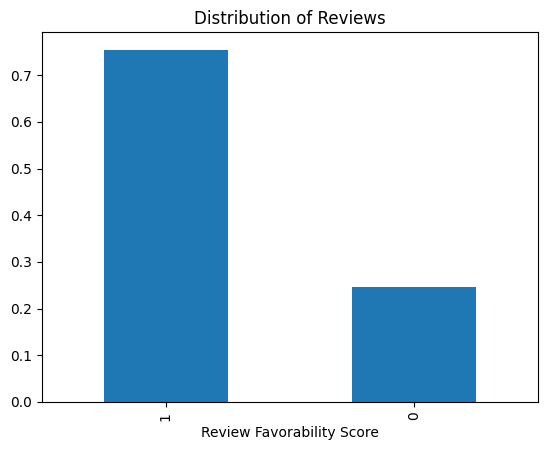

In [19]:
# majority of games are viewed favorably
reviews["review_score"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribution of Reviews")
plt.xlabel("Review Favorability Score")
plt.show()

In [20]:
# least reviewed games
app_review_count = reviews["app_name"].value_counts(dropna=False).reset_index()

app_remove_least = app_review_count[app_review_count["count"] < 301]["app_name"].tolist()

In [21]:
# remove games from dataset
reviews = reviews[~reviews["app_name"].isin(app_remove_least)].copy(deep=True)

In [22]:
target_names = ['NOT TRAVEL','TRAVEL']

## Data Balance

In [23]:
# take an even number of samples from each group: positive and negative
positive_rev = reviews[reviews["review_score"] == 1].sample(n=18000)
negative_rev = reviews[reviews["review_score"] == 0].sample(n=18000)

In [24]:
review_sample = pd.concat([positive_rev, negative_rev])

In [25]:
review_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 1657572 to 534213
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   app_id          36000 non-null  int64 
 1   app_name        36000 non-null  object
 2   review_text     36000 non-null  object
 3   review_score    36000 non-null  int64 
 4   review_votes    36000 non-null  int64 
 5   word_count      36000 non-null  int64 
 6   count_no_punct  36000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.2+ MB


## Data Modeling

In [26]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "review_text",
    label_columns=["review_score"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="bert",
    verbose=1
)

['not_review_score', 'review_score']
         not_review_score  review_score
5631646               1.0           0.0
2510776               1.0           0.0
5413625               0.0           1.0
3553776               1.0           0.0
5590023               1.0           0.0
['not_review_score', 'review_score']
         not_review_score  review_score
3747662               0.0           1.0
2028145               0.0           1.0
2518814               0.0           1.0
5165016               0.0           1.0
3665571               1.0           0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [27]:
model = ktrain.text.text_classifier("bert", train, preproc=preprocess)

Is Multi-Label? False
maxlen is 512


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [28]:
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=8)

In [29]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...


/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/6
4050/4050 [==============================] - 2572s 621ms/step - loss: 0.4655 - accuracy: 0.7728
Epoch 2/6
4050/4050 [==============================] - 2514s 621ms/step - loss: 0.2501 - accuracy: 0.8989
Epoch 3/6
4050/4050 [==============================] - 2514s 621ms/step - loss: 0.5935 - accuracy: 0.6128
Epoch 4/6
4050/4050 [==============================] - 1365s 337ms/step - loss: 0.8232 - accuracy: 0.4975


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


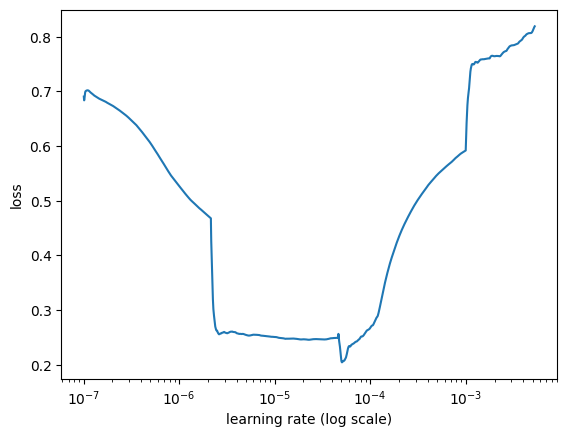

In [30]:
learner.lr_plot()

In [31]:
history=learner.autofit(
    1e-5,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/10
4050/4050 [==============================] - 2649s 645ms/step - loss: 0.2755 - accuracy: 0.8837 - val_loss: 0.1847 - val_accuracy: 0.9264
Epoch 2/10
4050/4050 [==============================] - 2605s 643ms/step - loss: 0.1589 - accuracy: 0.9392 - val_loss: 0.1786 - val_accuracy: 0.9314
Epoch 3/10
4050/4050 [==============================] - 2606s 643ms/step - loss: 0.1021 - accuracy: 0.9634 - val_loss: 0.1912 - val_accuracy: 0.9325
Epoch 3: early stopping
Weights from best epoch have been loaded into model.


In [32]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [33]:
validation = learner.validate(val_data=val, print_report=True)

113/113 [==============================] - 91s 725ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1754
           1       0.94      0.92      0.93      1846

    accuracy                           0.93      3600
   macro avg       0.93      0.93      0.93      3600
weighted avg       0.93      0.93      0.93      3600

